In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

from src.dataset.dataset import FurnitureImageDataset
from src.behavior import get_actor
from src.common.files import get_processed_paths
from src.common.control import ControlMode
from src.dataset.normalizer import LinearNormalizer
import torch
from pathlib import Path
from tqdm import trange, tqdm
from src.common.pytorch_util import dict_apply
from omegaconf import OmegaConf, DictConfig
from src.visualization.render_mp4 import data_to_video, create_mp4_jupyter
from wandb import Api
import cv2
import numpy as np

from torch.utils.data import DataLoader


api = Api()

In [3]:
def convert_state_dict(state_dict):
    if not any(k.startswith("encoder1.0") for k in state_dict.keys()) and not any(
        k.startswith("encoder1.model.nets.3") for k in state_dict.keys()
    ):
        print("Dict already in the correct format")
        return

    # Change all instances of "encoder1.0" to "encoder1" and "encoder2.0" to "encoder2"
    # and all instances of "encoder1.1" to encoder1_proj and "encoder2.1" to "encoder2_proj"
    for k in list(state_dict.keys()):
        if k.startswith("encoder1.0"):
            new_k = k.replace("encoder1.0", "encoder1")
            state_dict[new_k] = state_dict.pop(k)
        elif k.startswith("encoder2.0"):
            new_k = k.replace("encoder2.0", "encoder2")
            state_dict[new_k] = state_dict.pop(k)
        elif k.startswith("encoder1.1"):
            new_k = k.replace("encoder1.1", "encoder1_proj")
            state_dict[new_k] = state_dict.pop(k)
        elif k.startswith("encoder2.1"):
            new_k = k.replace("encoder2.1", "encoder2_proj")
            state_dict[new_k] = state_dict.pop(k)

    return state_dict

In [4]:
run = api.run("sweeps/runs/brsbq5d2")
cfg = OmegaConf.create(run.config)

In [5]:
[file for file in run.files() if file.name.endswith(".pt")]

[<File models/honest-sweep-31/actor_chkpt_best_test_loss.pt (application/vnd.snesdev-page-table) 1.1GiB>]

In [6]:
model_wts = (
    [file for file in run.files() if file.name.endswith(".pt")][0]
    .download(replace=False, exist_ok=True)
    .name
)

In [43]:
file_paths = get_processed_paths(
    environment="sim",
    task="one_leg",
    demo_outcome="success",
    demo_source="teleop",
    randomness="low",
)

normalizer = LinearNormalizer(
    control_mode=ControlMode.delta,
)

# Make the dataset
dataset_success = FurnitureImageDataset(
    dataset_paths=file_paths,
    action_horizon=8,
    pred_horizon=32,
    augment_image=False,
    obs_horizon=1,
    control_mode=ControlMode.delta,
    data_subset=None,
    normalizer=normalizer,
)

Found the following paths:
    /data/scratch/ankile/furniture-data/processed/sim/one_leg/teleop/low/success.zarr


Loading zarr files:   0%|          | 0/1 [00:00<?, ?it/s]

























































Loading zarr files: 100%|██████████| 1/1 [00:06<00:00,  6.47s/it]


Loading dataset of 50 episodes


In [8]:
actor = get_actor(
    device="cuda",
    normalizer=normalizer.get_copy(),
    config=cfg,
)

actor.load_state_dict(convert_state_dict(torch.load(model_wts)))

/data/scratch/ankile/miniconda3/envs/rlgpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using inference steps: 16
Total parameters: 304.09M
normalizer: 0.00M parameters
encoder1: 11.19M parameters
encoder2: 11.19M parameters
encoder1_proj: 0.03M parameters
encoder2_proj: 0.03M parameters
model: 281.64M parameters
loss_fn: 0.00M parameters


<All keys matched successfully>

In [44]:
f"Number of episodes: {len(dataset_success.episode_ends)}, number of images: {len(dataset_success)}, final episode_end: {dataset_success.episode_ends[-1]}"

'Number of episodes: 50, number of images: 27820, final episode_end: 29020'

In [191]:
dataset_success.skills.sum()

32

## Look at some example predicted actions

torch.Size([10])
tensor([ 2.0924e-03, -3.6220e-04, -2.9118e-03,  9.9976e-01,  1.6318e-02,
         1.2173e-02, -1.6722e-02,  9.9855e-01, -2.3244e-02,  9.9879e-01])
tensor([0.0051, 0.0011, 0.0050, 0.0008, 0.0187, 0.0158, 0.0200, 0.0017, 0.0261,
        0.0029])
tensor([ 2.4336e+00, -2.9396e+00, -1.7277e+00,  7.9088e-04,  1.1472e+00,
         1.3014e+00, -1.1944e+00,  1.6582e-03, -1.1240e+00,  2.8626e-03])
0.009548574
0.0057855444
0.60590667


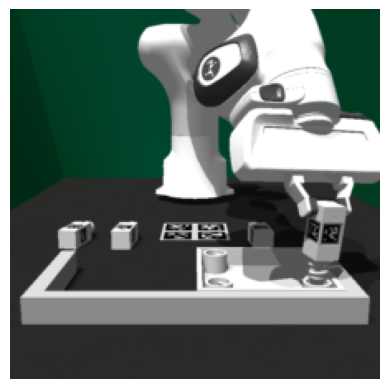

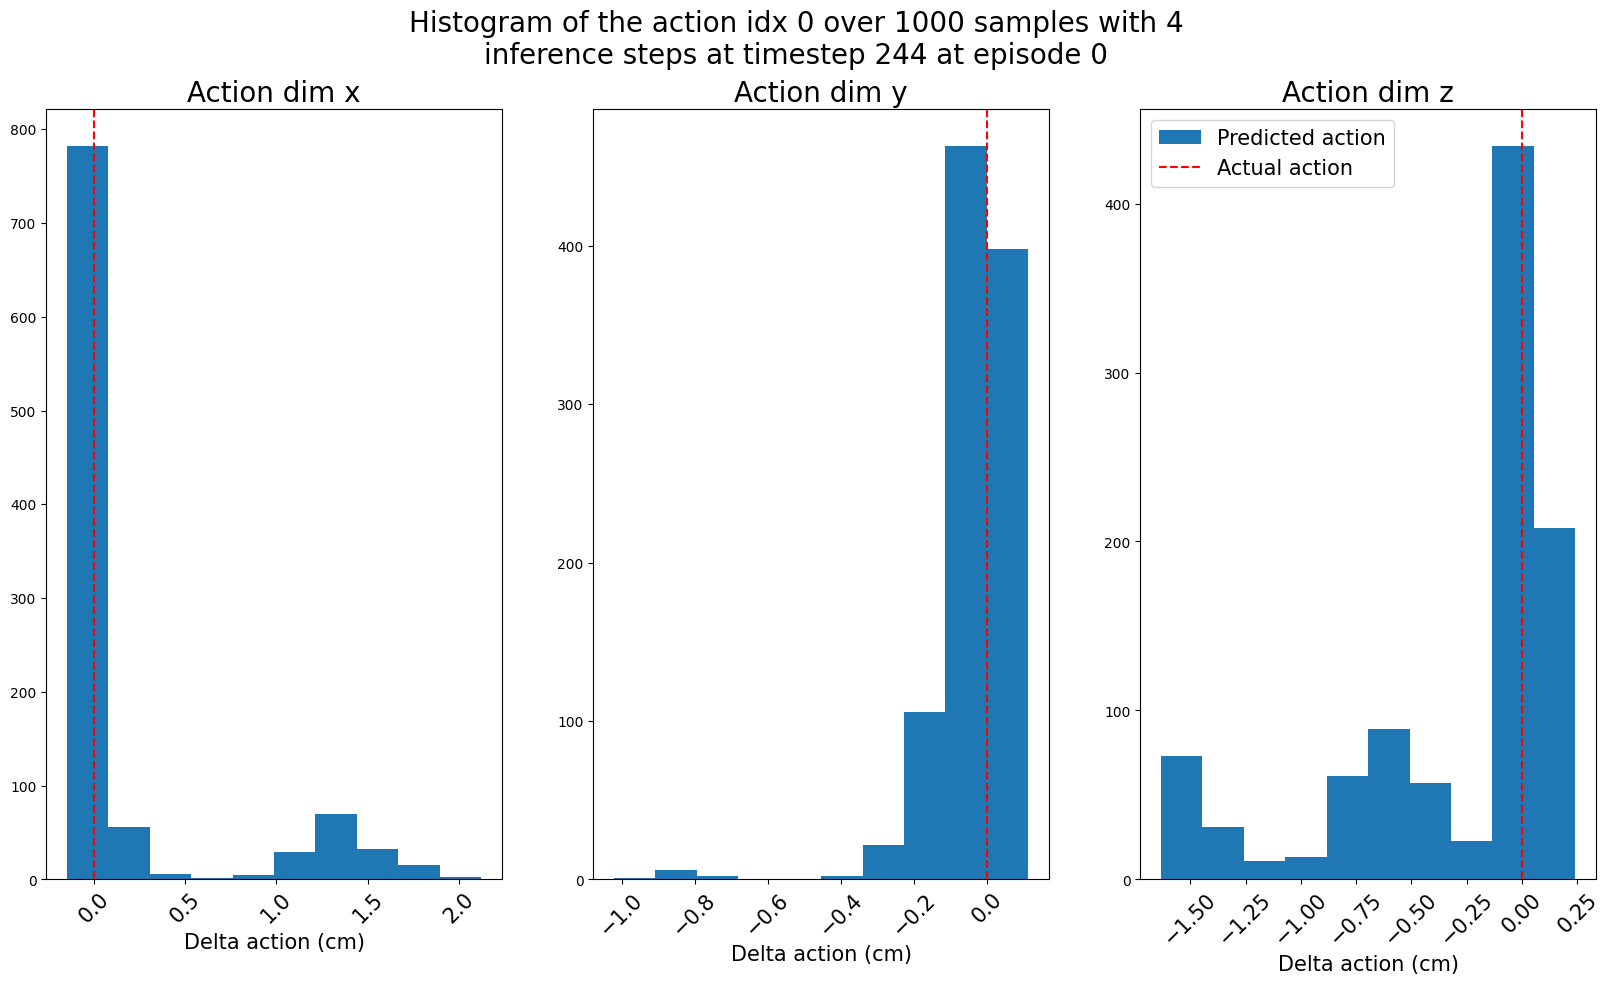

In [267]:
def plot_action_histogram(dataset, ep_idx, insertion_offset):

    # Find the end of the first episode
    ep_start = dataset_success.episode_ends[ep_idx - 1] if ep_idx > 0 else 0
    ep_end = dataset_success.episode_ends[ep_idx]

    # Find the index of the insertion action
    insertion_skill_idx = 3

    # Find the index of the 3rd time skills is 1
    insertion_idx = np.where(dataset_success.skills[ep_start:ep_end] == 1)[0][
        insertion_skill_idx
    ]

    timestep = ep_start + insertion_idx - insertion_offset

    batch = dataset[timestep]

    n_samples = 1000
    actor.inference_steps = 4

    with torch.no_grad():
        batch = dict_apply(
            batch, lambda x: x.to("cuda", non_blocking=True).unsqueeze(0)
        )
        nobs = actor._training_obs(batch)

        # Repeat the nobs n_samples times to get a good average
        nobs = nobs.repeat(n_samples, 1)

        # Predict normalized action
        naction = actor._normalized_action(nobs)

        # unnormalize action
        # (B, pred_horizon, action_dim)
        actions = actor.normalizer(naction, "action", forward=False)[:, :8].cpu()

    unnormalized_action_taken = actor.normalizer(
        batch["action"][0, :8, :], "action", forward=False
    ).cpu()

    # Show an image from the batch
    plt.imshow(batch["color_image2"][0][0].cpu().numpy())

    # Turn of the axis
    plt.axis("off")
    # Calculate the mean and std of the actions (look at only the first action)
    mean = actions.mean(dim=0)[0]
    std = actions.std(dim=0)[0]

    # Calculate the magnitude of the xyz of the actions
    action_mags = np.linalg.norm(actions.numpy()[:, :, :3].reshape(-1, 3), axis=1)

    # Calculate the mean and std of the action magnitudes
    mean_mag = action_mags.mean()
    std_mag = action_mags.std()

    print(mean.shape)

    print(mean)
    print(std)
    print(std / mean)

    print(mean_mag)
    print(std_mag)
    print(std_mag / mean_mag)
    # Show a histogram over the n samples for each of the x, y, z, and the magnitude of the action
    # Control what action in the prediction sequence to look at [0, 7]
    histogram_action_index = 0

    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    for i, coord in enumerate(["x", "y", "z"]):
        ax = axs[i]
        ax.hist(
            actions[:, histogram_action_index, i].cpu().numpy() * 100,
            label="Predicted action",
        )
        ax.set_title(f"Action dim {coord}", fontsize=20)

        # Add the actual action take as a vertical line
        ax.axvline(
            unnormalized_action_taken[histogram_action_index, i].numpy() * 100,
            color="r",
            linestyle="--",
            label="Actual action",
        )

        # Set the x-axis tixck labels at an angle and increase the font size
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_fontsize(15)

        # Set label on the x-axis
        ax.set_xlabel("Delta action (cm)", fontsize=15)

    axs[-1].legend(fontsize=15)

    fig.suptitle(
        f"Histogram of the action idx {histogram_action_index} over {n_samples} samples with {actor.inference_steps}\ninference steps at timestep {timestep-ep_start+insertion_offset} at episode {ep_idx}",
        fontsize=20,
    )

    plt.show()


plot_action_histogram(dataset_success, 0, 20)

## Look at the coefficient of variation of the predicted actions across an episode

In [16]:
def calculate_epi_stats(
    dataset, actor, ep_start, ep_end, action_batch=8, samples=100, batch_size=100
):
    means = []
    stds = []
    cvs = []
    actuals = []

    for i in trange(ep_start, ep_end, batch_size * action_batch):
        end_idx = min(i + batch_size * action_batch, ep_end)

        # Manually make a batch
        batch = {
            k: torch.stack([dataset[i][k] for i in range(i, end_idx, action_batch)])
            for k in dataset[0].keys()
        }

        with torch.no_grad():
            batch = dict_apply(batch, lambda x: x.to("cuda", non_blocking=True))

            actual_action = actor.normalizer(
                batch["action"][:, :8].reshape(-1, 10),
                "action",
                forward=False,
            ).cpu()

            # Store the actual actions
            actuals.extend(actual_action)

            # Shape of nobs is (B, obs_dim)
            nobs = actor._training_obs(batch)

            # Repeat the nobs 100 times for each sample in the batch
            # Shape of nobs is now (B, 1, obs_dim)
            nobs = nobs.unsqueeze(1)

            # Repeat the nobs {samples} times to get a good average
            # Shape of nobs is now (B, samples, obs_dim)
            nobs = nobs.repeat(1, samples, 1)

            # Reshape to (B * samples, obs_dim)
            nobs = nobs.view(-1, nobs.shape[-1])

            # Predict normalized action
            # Shape of naction is (B * samples, pred_horizon, action_dim)
            naction = actor._normalized_action(nobs)

            # Reshape to (B, samples, pred_horizon, action_dim)
            naction = naction.view(-1, samples, naction.shape[-2], naction.shape[-1])

            # unnormalize action
            # (B, samples, pred_horizon, action_dim)
            actions = actor.normalizer(naction, "action", forward=False)[:, :, :8].cpu()

        # Calculate the mean and std of the actions over the samples dimension (axis=1)

        mean = actions.mean(dim=1).reshape(-1, 10)
        std = actions.std(dim=1).reshape(-1, 10)

        # Add to the list
        means.extend(mean)
        stds.extend(std)
        cvs.extend(std / mean)

    means = torch.stack(means)[: ep_end - ep_start]
    stds = torch.stack(stds)[: ep_end - ep_start]
    cvs = torch.stack(cvs)[: ep_end - ep_start]
    actuals = torch.stack(actuals)[: ep_end - ep_start]

    return means, stds, cvs, actuals


means, stds, cvs, actuals = calculate_epi_stats(
    dataset, actor, ep_start, ep_end, action_batch=8, samples=100, batch_size=100
)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.59s/it]


In [17]:
means.shape, stds.shape, cvs.shape, actuals.shape

(torch.Size([535, 10]),
 torch.Size([535, 10]),
 torch.Size([535, 10]),
 torch.Size([535, 10]))

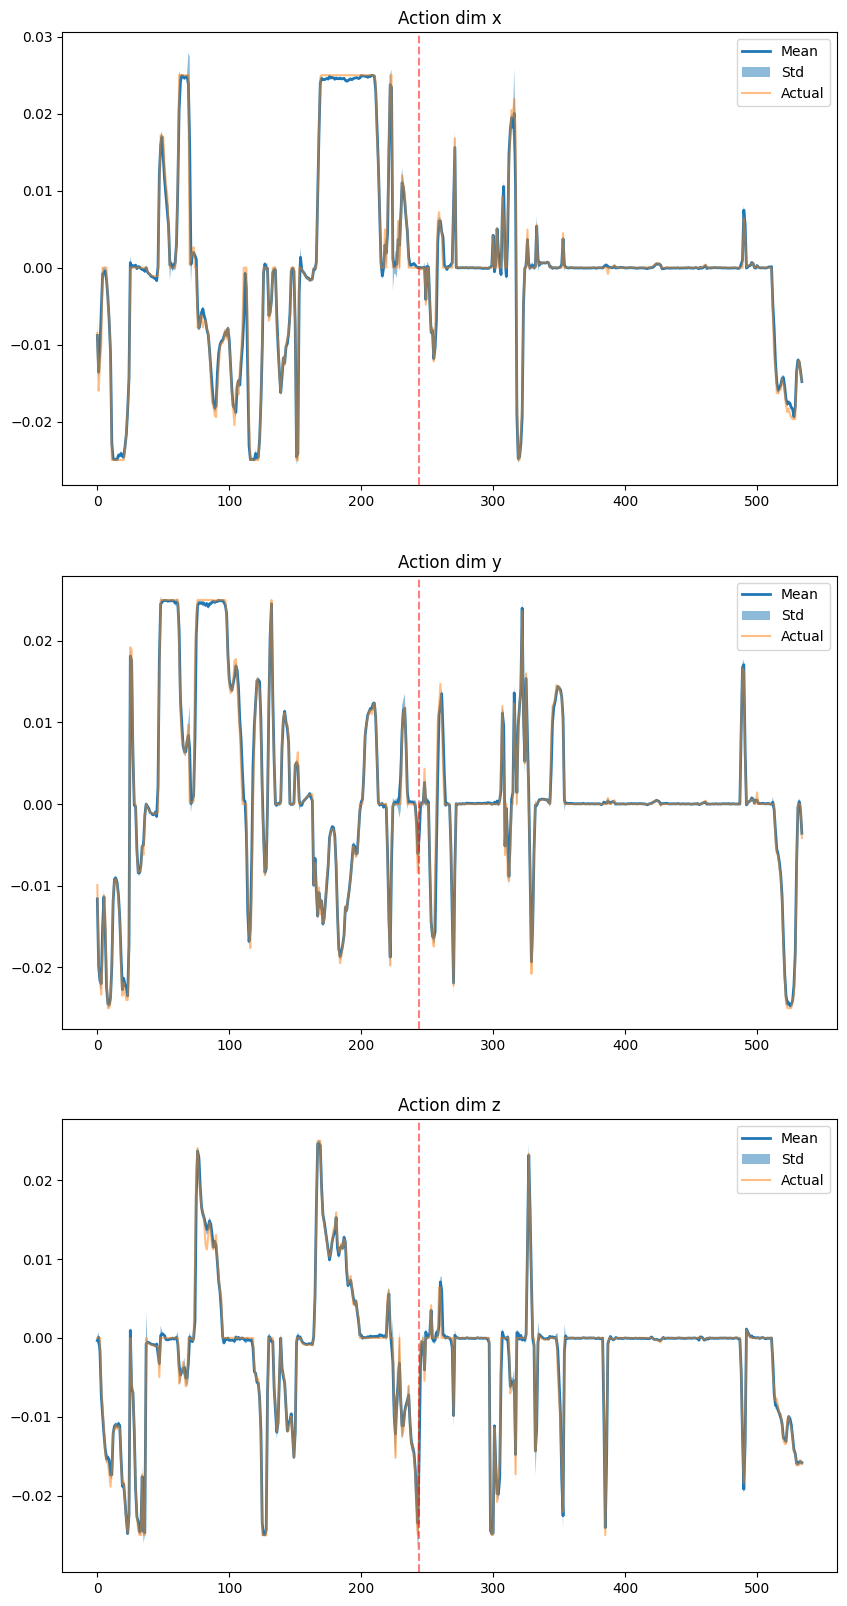

In [18]:
# Do the same as above but focus on xyz deltas
# Plot the mean and std over time for each of the 8 action dimensions where the mean is a line and the std is a shaded area
def plot_episode(means, stds, actuals, insertion_idx=None):
    fig, axs = plt.subplots(3, 1, figsize=(10, 20))
    for i, coord in enumerate(["x", "y", "z"]):
        ax = axs[i]
        ax.plot(means[:, i].cpu().numpy(), label="Mean", linewidth=2)
        ax.fill_between(
            range(ep_end - ep_start),
            (means - stds)[:, i].cpu().numpy(),
            (means + stds)[:, i].cpu().numpy(),
            alpha=0.5,
            label="Std",
        )

        # Plot the actual actions
        ax.plot(actuals[:, i].cpu().numpy(), label="Actual", alpha=0.5)

        ax.set_title(f"Action dim {coord}")
        ax.legend()

        # Put a vertical line at the insertion_idx
        if insertion_idx is not None:
            ax.axvline(
                insertion_idx,
                color="r",
                linestyle="--",
                label="Insertion idx",
                alpha=0.5,
            )


plot_episode(means, stds, actuals, insertion_idx)

# fig.suptitle(
#     f"Mean and std of the action over {n_samples} samples\nwith {actor.inference_steps} inference steps at timestep {timestep}",
#     fontsize=16,
# )

### Plot only the variance throughout the episode

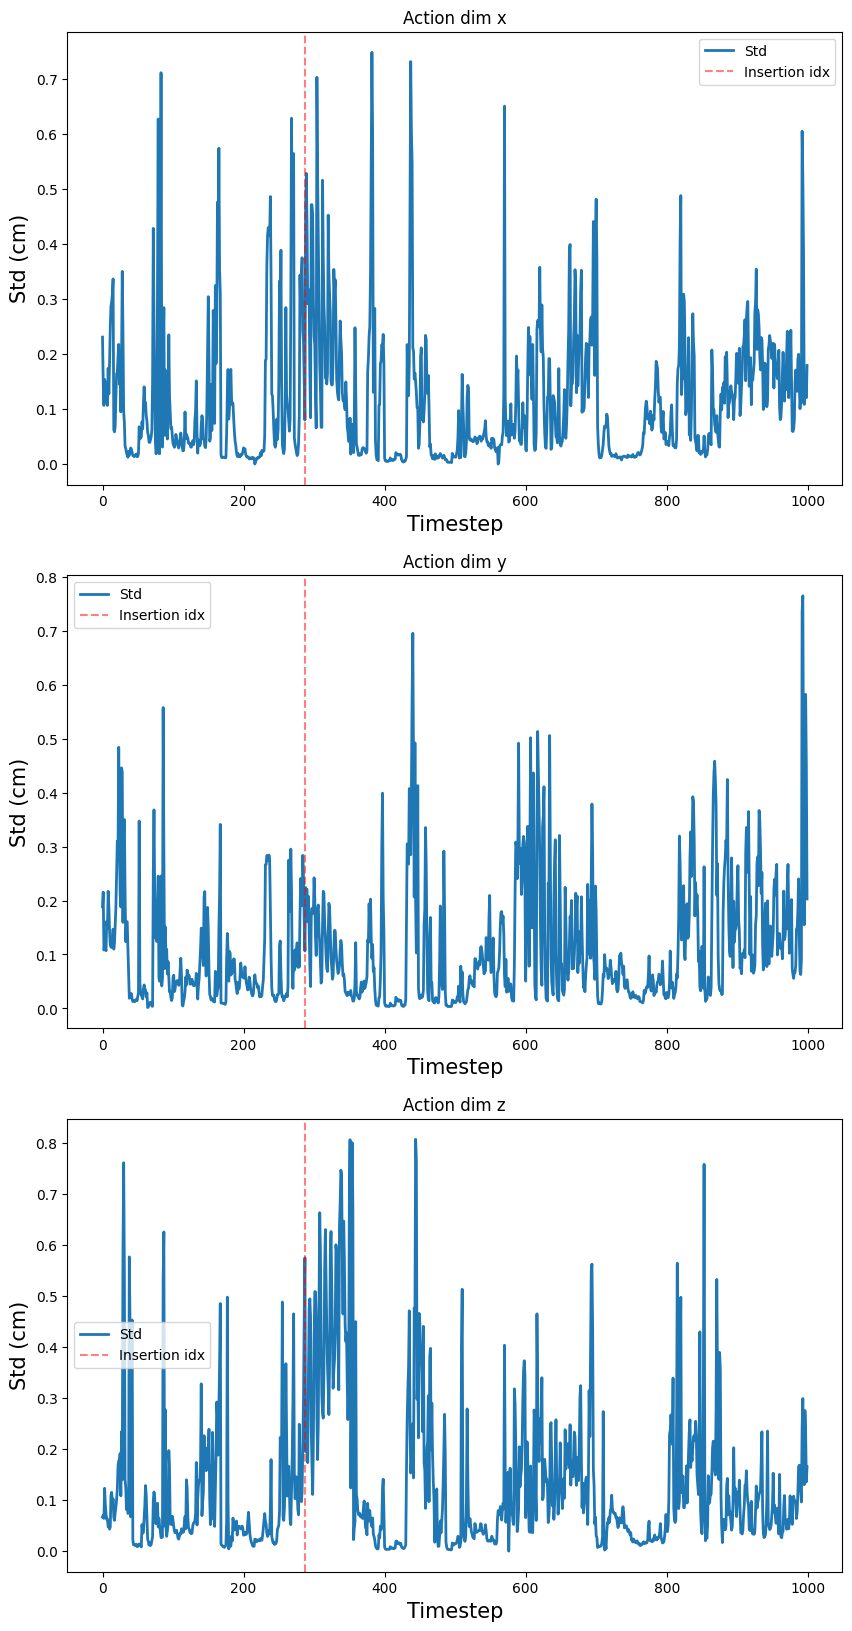

In [163]:
# Plot the standard deviation over time for each of the x, y, and z dimensions
fig, axs = plt.subplots(3, 1, figsize=(10, 20))
for i, coord in enumerate(["x", "y", "z"]):
    ax = axs[i]
    ax.plot(stds[:, i].cpu().numpy() * 100, label="Std", linewidth=2)

    # Put a vertical line at the insertion_idx
    if insertion_idx is not None:
        ax.axvline(
            insertion_idx,
            color="r",
            linestyle="--",
            label="Insertion idx",
            alpha=0.5,
        )

    # Add label to the x-axis
    ax.set_xlabel("Timestep", fontsize=15)

    # Add title to the y-axis
    ax.set_ylabel("Std (cm)", fontsize=15)

    ax.set_title(f"Action dim {coord}")
    ax.legend()

## Load in a dataset of failures to look at something more OOD

In [231]:
file_paths = get_processed_paths(
    environment="sim",
    task="one_leg",
    demo_outcome="failure",
    demo_source="rollout",
    randomness="low",
)

normalizer = LinearNormalizer(
    control_mode=ControlMode.delta,
)

# Make the dataset
dataset_failure = FurnitureImageDataset(
    dataset_paths=file_paths,
    action_horizon=8,
    pred_horizon=32,
    augment_image=False,
    obs_horizon=1,
    control_mode=ControlMode.delta,
    data_subset=None,
    normalizer=normalizer,
)

Found the following paths:
    /data/scratch/ankile/furniture-data/processed/sim/one_leg/rollout/low/failure.zarr


Loading zarr files:   0%|          | 0/1 [00:00<?, ?it/s]




















Loading zarr files: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

Loading dataset of 6 episodes


torch.Size([10])
tensor([ 5.9972e-04,  8.8505e-05, -6.8308e-04,  9.8702e-01,  1.4738e-02,
         1.6268e-01, -2.6579e-02,  9.9811e-01,  6.2647e-02,  9.9274e-01])
tensor([0.0005, 0.0002, 0.0004, 0.0006, 0.0027, 0.0043, 0.0028, 0.0003, 0.0031,
        0.0044])
tensor([ 8.4672e-01,  2.5455e+00, -5.2377e-01,  5.9778e-04,  1.8352e-01,
         2.6283e-02, -1.0385e-01,  2.5278e-04,  4.9980e-02,  4.4222e-03])
0.0054755826
0.0047330866
0.8643987


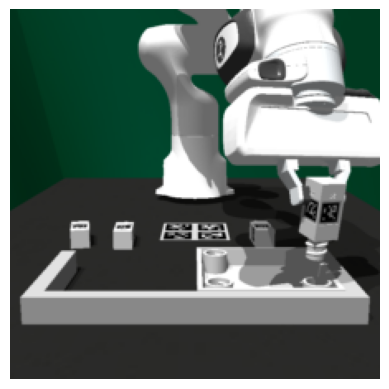

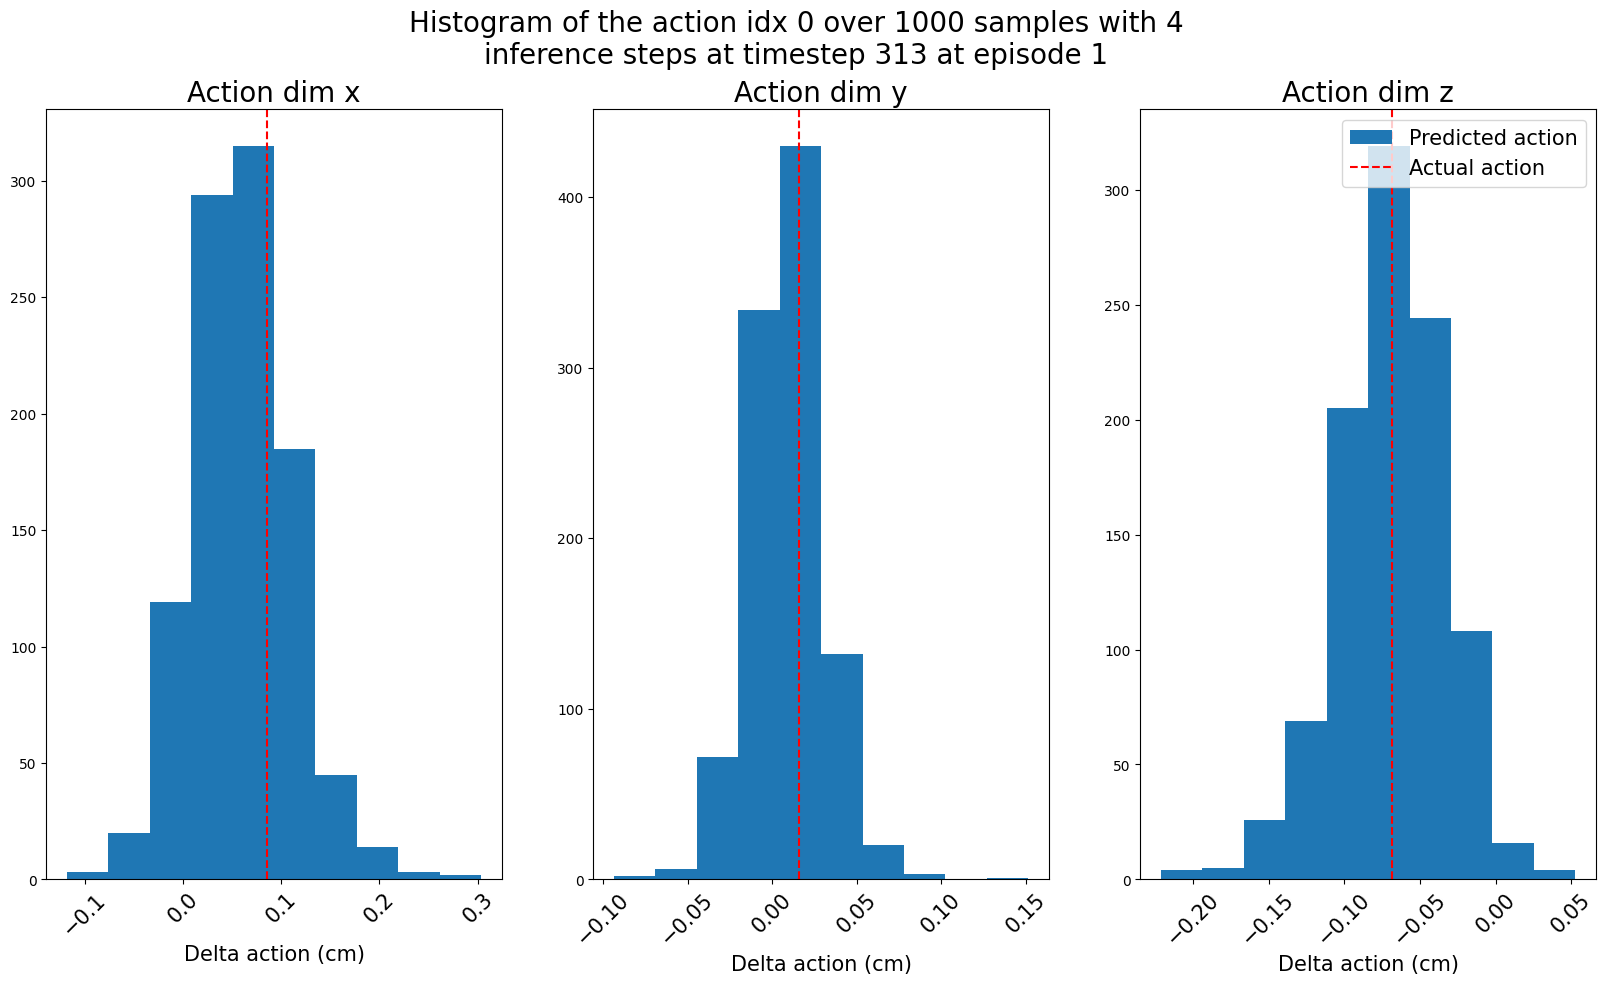

torch.Size([10])
tensor([-4.2396e-04,  2.3657e-04, -2.3807e-02,  9.9999e-01,  1.9714e-04,
        -2.3734e-03, -8.2237e-04,  9.9986e-01, -5.3670e-06,  9.9894e-01])
tensor([2.5763e-04, 1.4541e-04, 4.9347e-04, 5.4202e-05, 1.1560e-03, 1.5550e-03,
        1.1702e-03, 9.6592e-05, 1.4021e-03, 1.9513e-03])
tensor([-6.0767e-01,  6.1466e-01, -2.0728e-02,  5.4203e-05,  5.8638e+00,
        -6.5518e-01, -1.4230e+00,  9.6606e-05, -2.6125e+02,  1.9534e-03])
0.012477872
0.0075967642
0.6088189


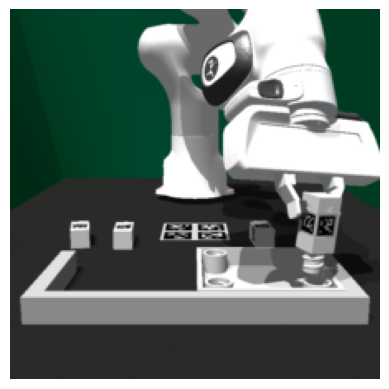

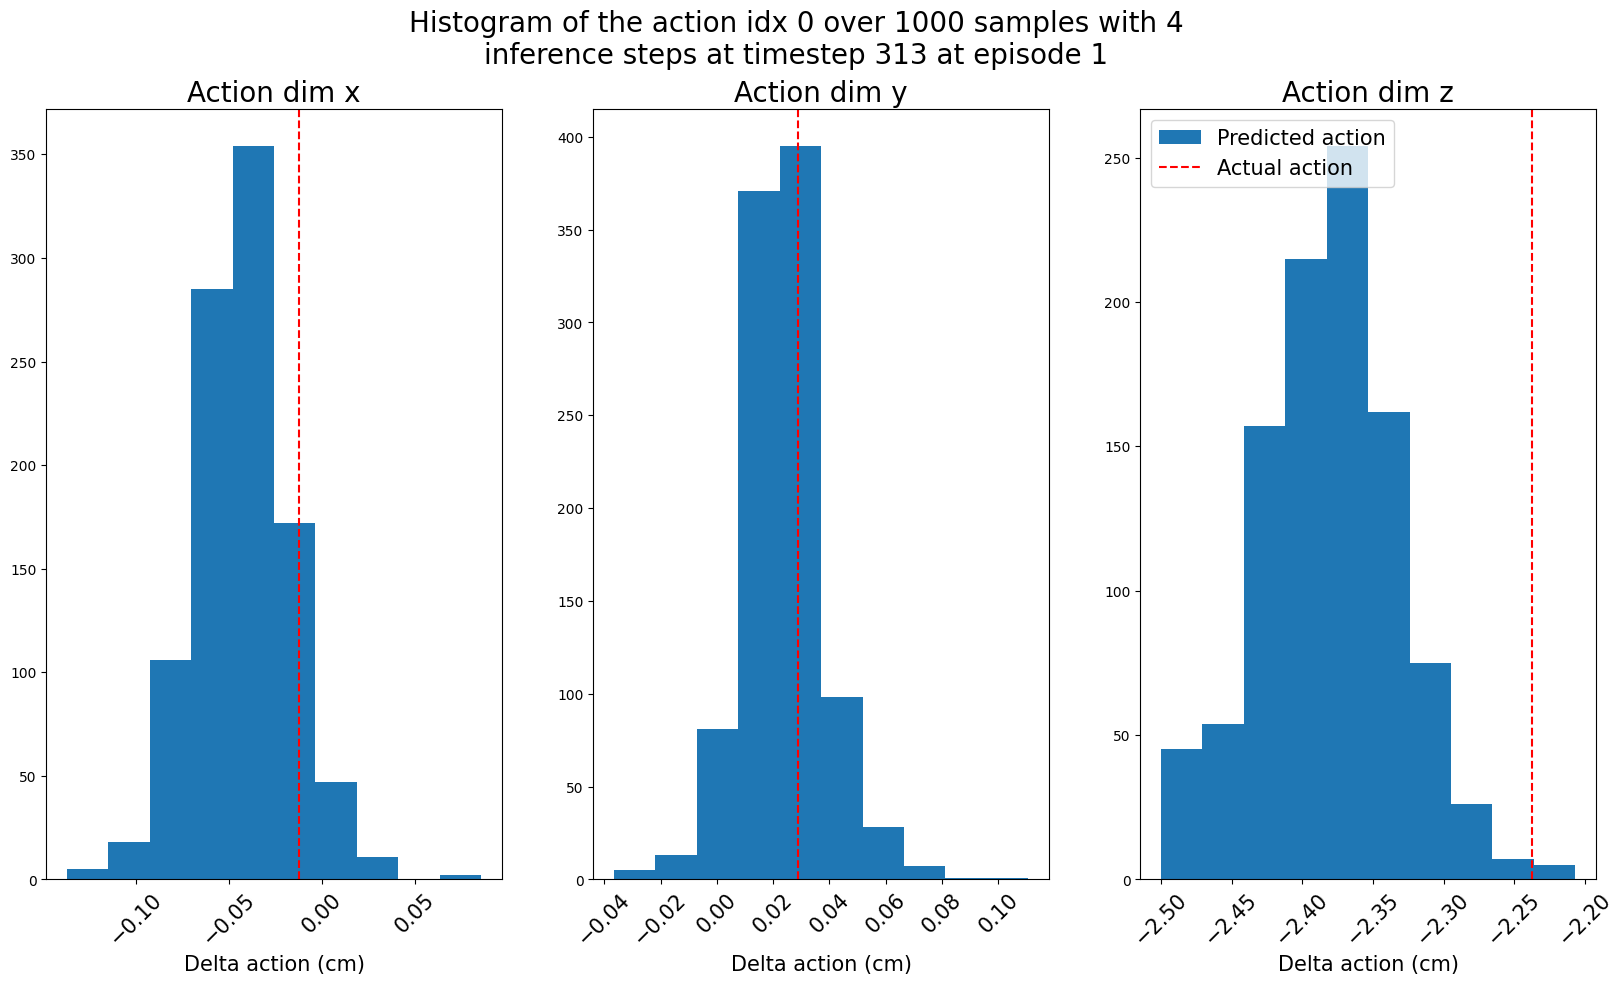

torch.Size([10])
tensor([-5.2734e-04,  1.0842e-03, -9.6007e-03,  9.9984e-01,  1.0914e-03,
         3.6998e-03, -1.1552e-03,  9.9993e-01, -6.5981e-04,  9.9763e-01])
tensor([4.7239e-04, 1.2113e-03, 9.3156e-04, 1.3862e-04, 2.1098e-03, 2.3546e-03,
        2.1622e-03, 9.4022e-05, 3.6300e-03, 2.7409e-03])
tensor([-8.9579e-01,  1.1172e+00, -9.7030e-02,  1.3864e-04,  1.9331e+00,
         6.3643e-01, -1.8717e+00,  9.4028e-05, -5.5016e+00,  2.7474e-03])
0.015271522
0.0046575204
0.30498075


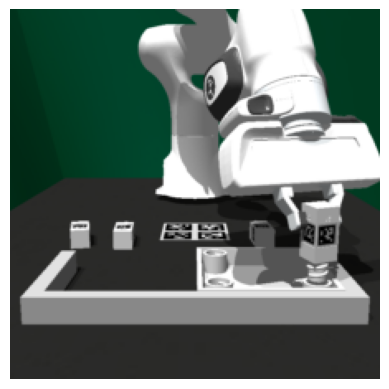

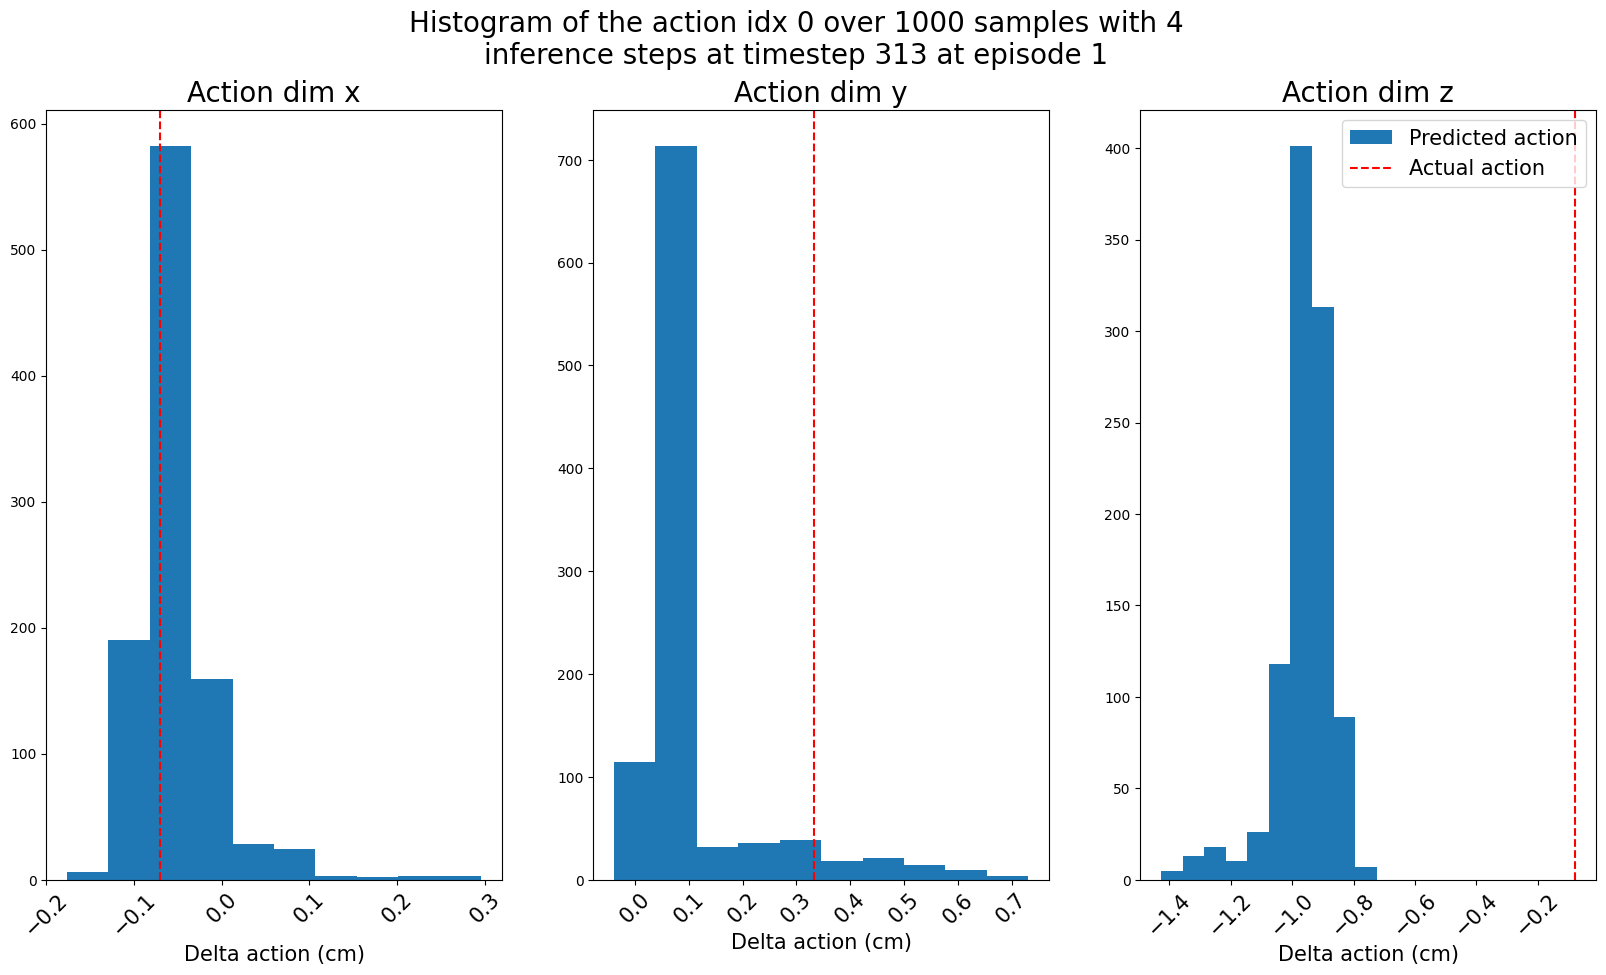

torch.Size([10])
tensor([ 0.0063, -0.0013, -0.0112,  0.9997, -0.0041,  0.0103,  0.0029,  0.9997,
         0.0018,  0.9945])
tensor([0.0039, 0.0018, 0.0023, 0.0003, 0.0062, 0.0066, 0.0061, 0.0003, 0.0091,
        0.0073])
tensor([ 6.1060e-01, -1.4181e+00, -2.0245e-01,  3.2903e-04, -1.5240e+00,
         6.4131e-01,  2.1398e+00,  2.6126e-04,  5.1590e+00,  7.3096e-03])
0.010016954
0.0045615556
0.4553835


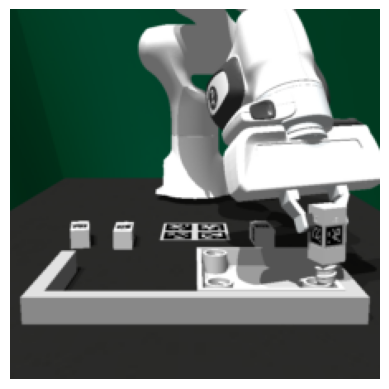

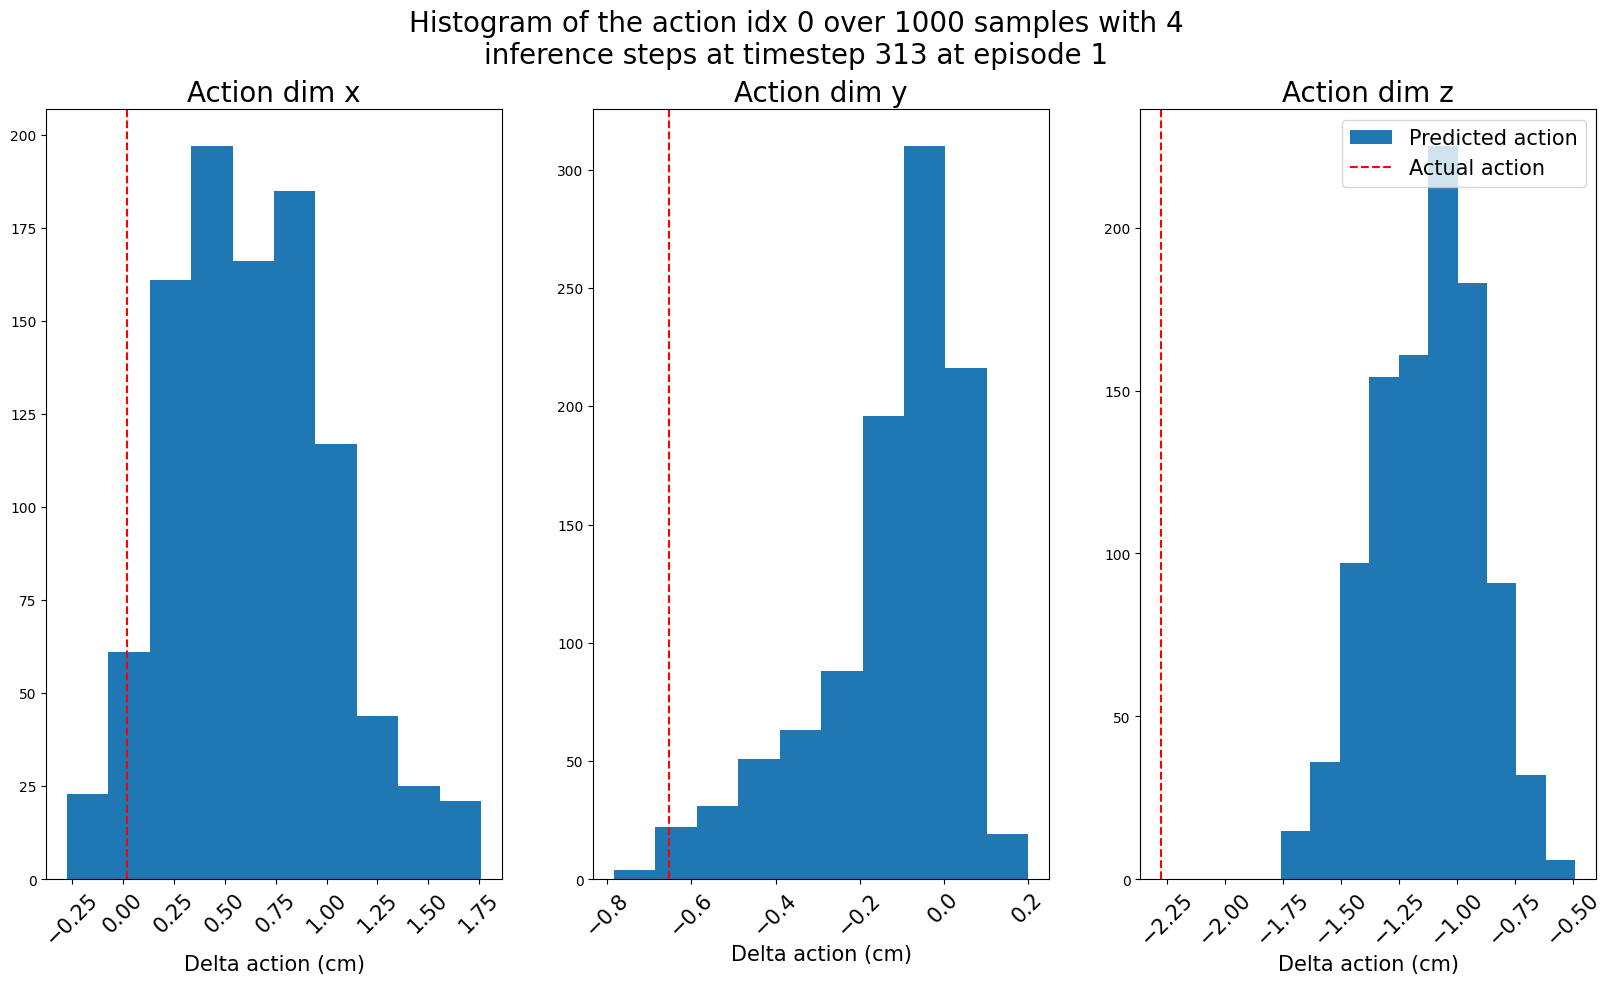

torch.Size([10])
tensor([ 8.9867e-04, -3.4465e-03, -4.2651e-03,  9.9990e-01, -4.0266e-04,
         1.1102e-03, -9.3911e-04,  9.9980e-01,  1.2881e-03,  9.9770e-01])
tensor([0.0052, 0.0022, 0.0021, 0.0002, 0.0068, 0.0094, 0.0067, 0.0002, 0.0103,
        0.0038])
tensor([ 5.7865e+00, -6.4680e-01, -4.8527e-01,  2.0561e-04, -1.6965e+01,
         8.4957e+00, -7.1309e+00,  2.1299e-04,  8.0205e+00,  3.7929e-03])
0.009946039
0.004454929
0.44790986


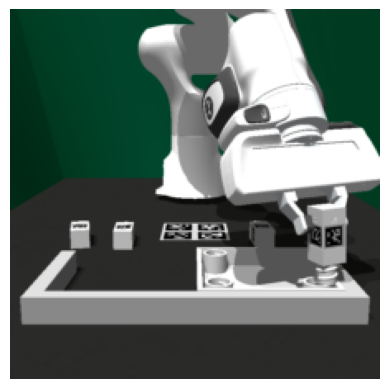

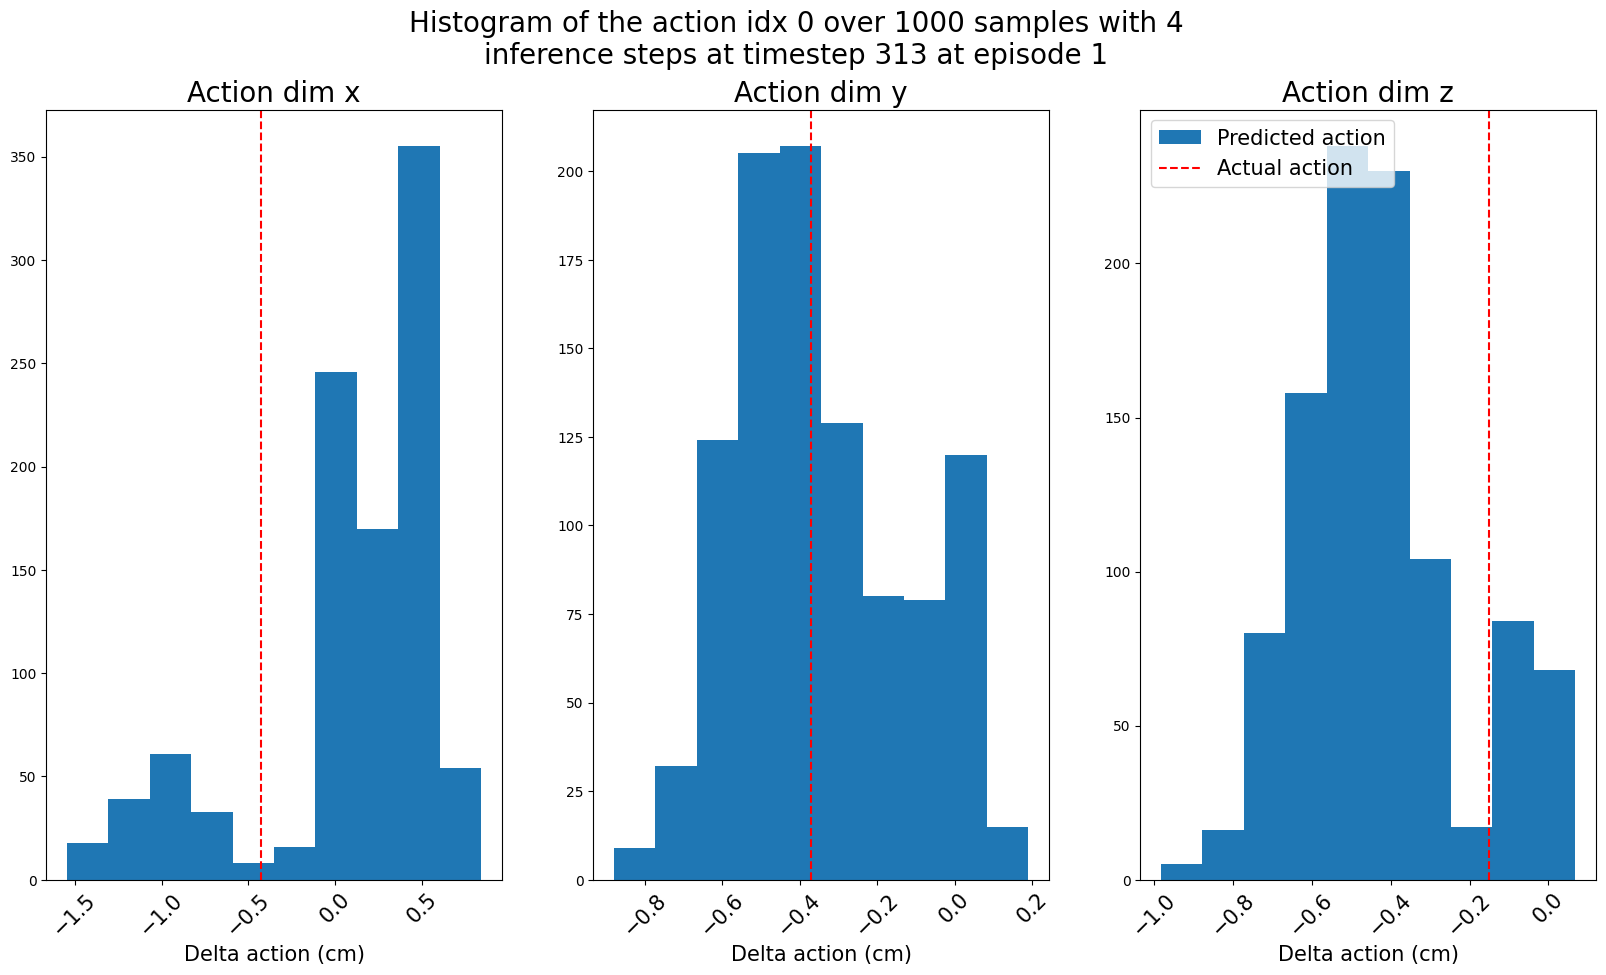

torch.Size([10])
tensor([-7.6797e-04, -6.1434e-03, -1.2116e-03,  9.9991e-01,  1.7973e-03,
         3.9224e-03, -2.7244e-03,  9.9980e-01,  4.7362e-03,  9.9831e-01])
tensor([0.0051, 0.0016, 0.0010, 0.0002, 0.0067, 0.0106, 0.0065, 0.0002, 0.0083,
        0.0031])
tensor([-6.6027e+00, -2.5325e-01, -8.2184e-01,  1.8710e-04,  3.7048e+00,
         2.7052e+00, -2.3990e+00,  1.9483e-04,  1.7601e+00,  3.1079e-03])
0.010175237
0.004719512
0.4638233


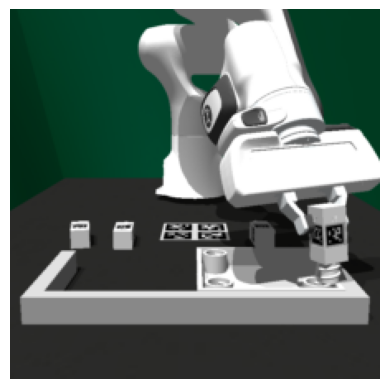

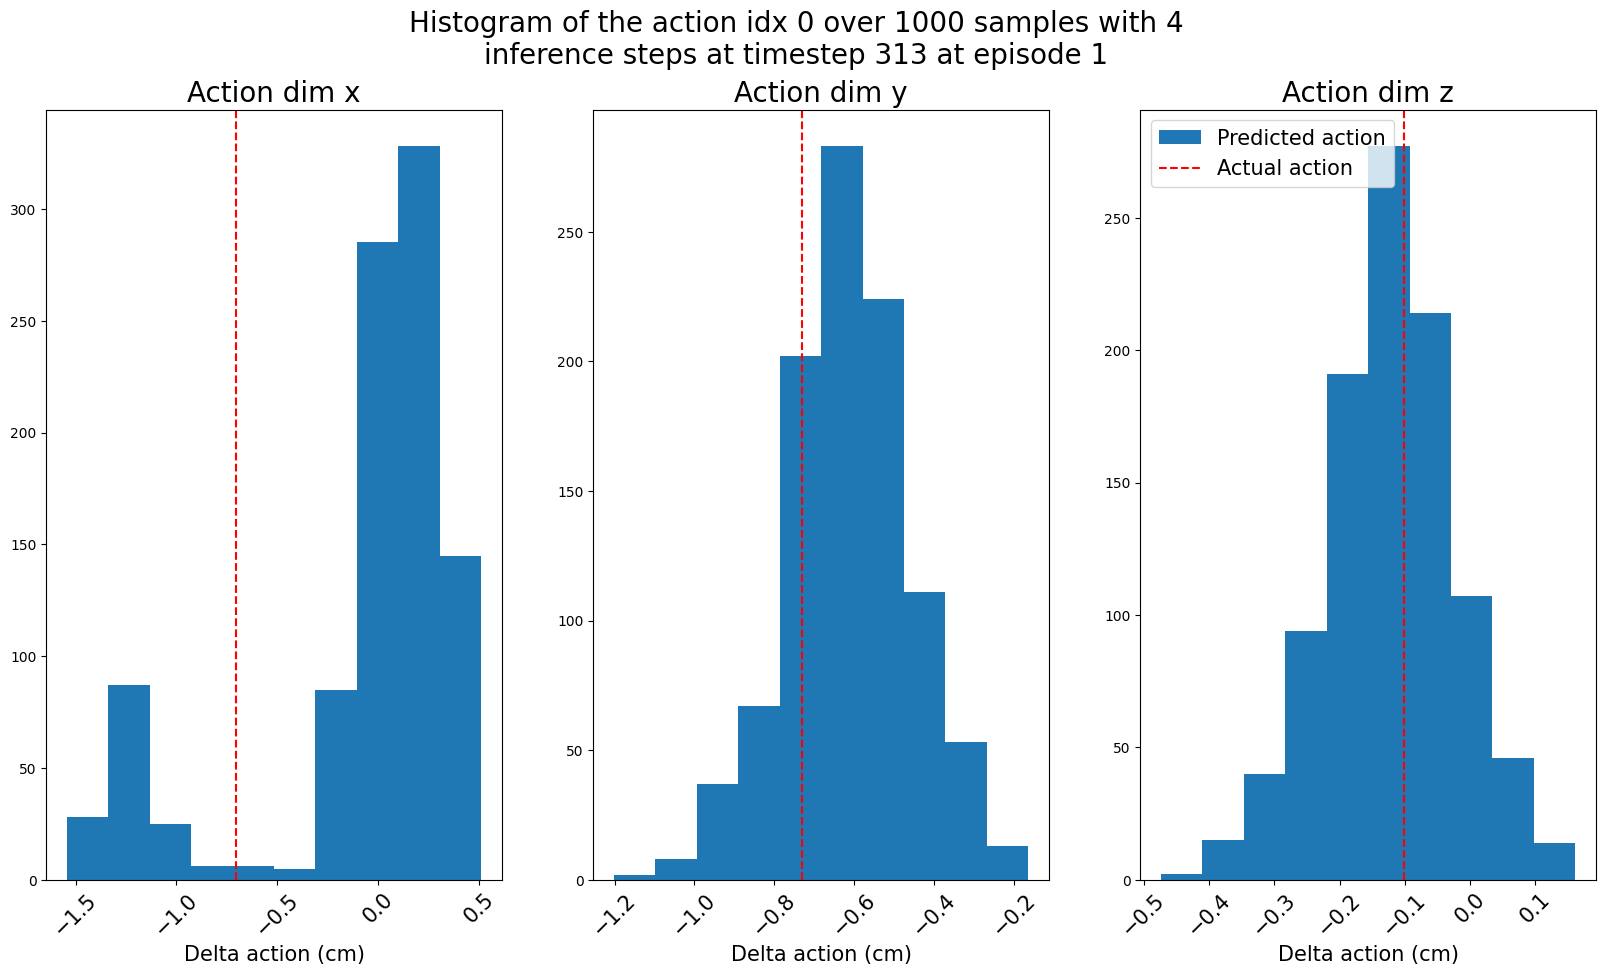

torch.Size([10])
tensor([-0.0081, -0.0023, -0.0014,  0.9996,  0.0153,  0.0130, -0.0163,  0.9998,
         0.0074,  0.9994])
tensor([0.0041, 0.0020, 0.0018, 0.0003, 0.0050, 0.0096, 0.0050, 0.0002, 0.0064,
        0.0017])
tensor([-5.0496e-01, -8.7003e-01, -1.3238e+00,  2.9453e-04,  3.2347e-01,
         7.3930e-01, -3.0476e-01,  1.6502e-04,  8.5686e-01,  1.7137e-03])
0.014457281
0.0056705563
0.39222842


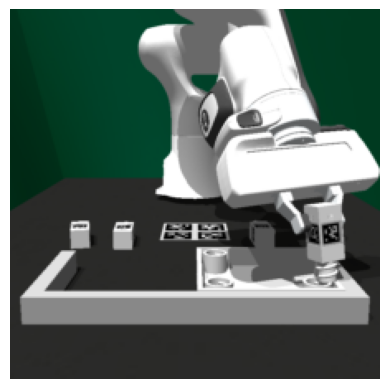

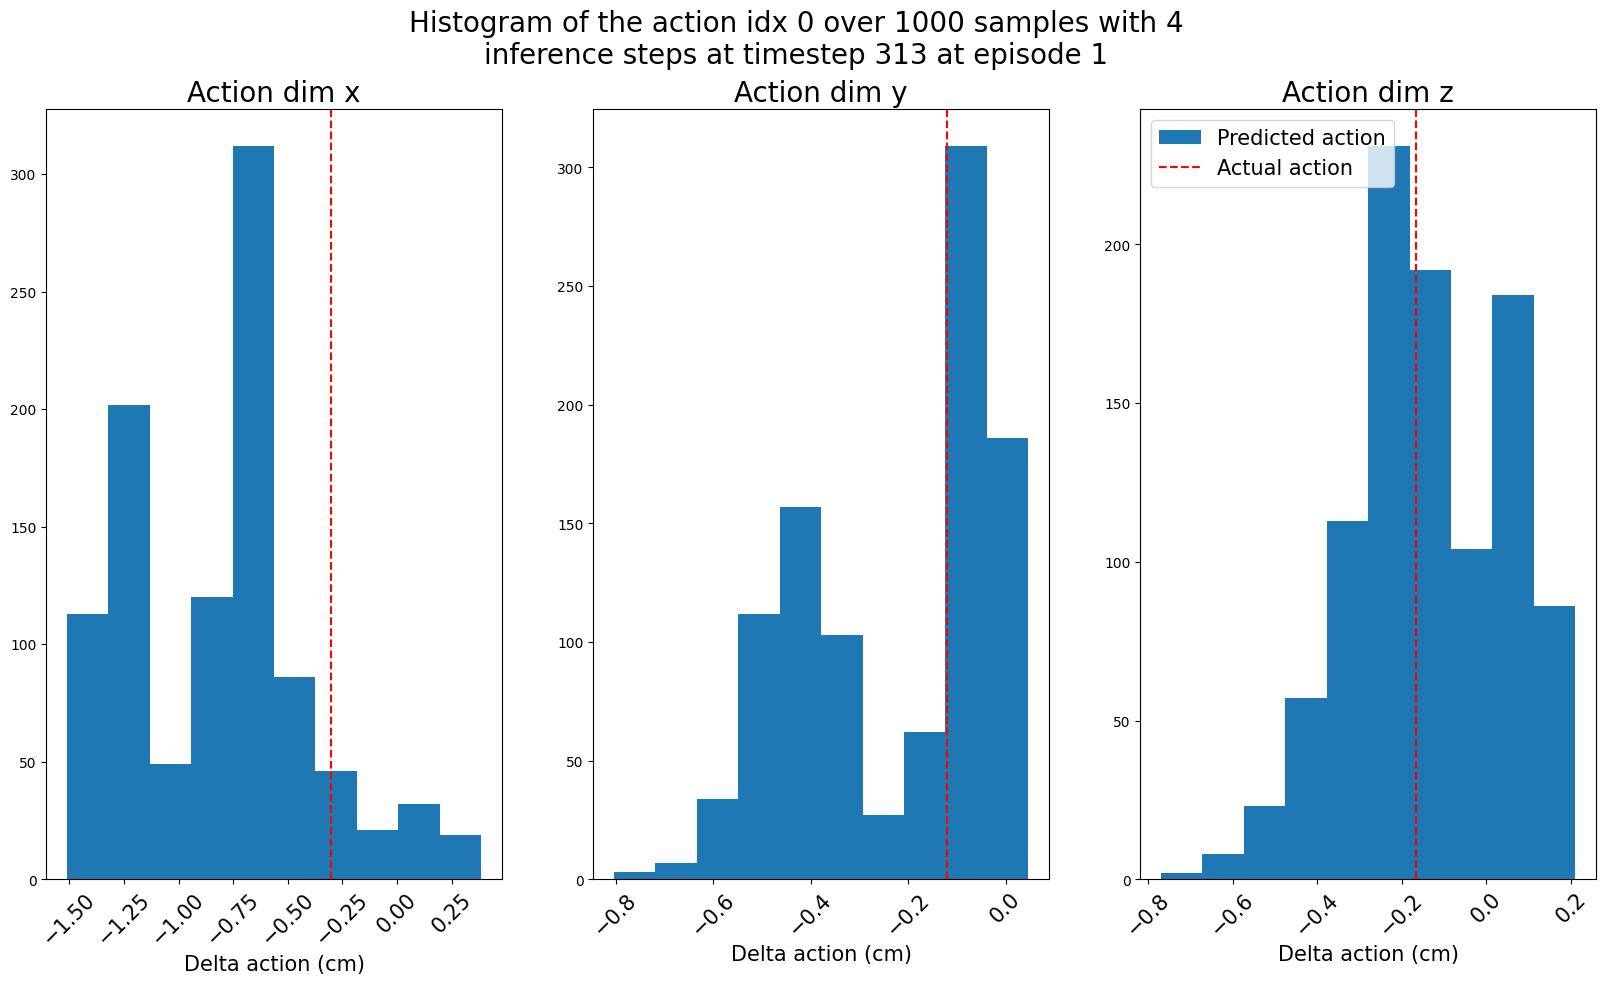

torch.Size([10])
tensor([-0.0034, -0.0016, -0.0034,  0.9998,  0.0100,  0.0069, -0.0108,  0.9998,
         0.0072,  0.9990])
tensor([0.0051, 0.0014, 0.0033, 0.0002, 0.0070, 0.0129, 0.0068, 0.0002, 0.0069,
        0.0032])
tensor([-1.5176e+00, -8.9231e-01, -9.6424e-01,  2.4985e-04,  6.9989e-01,
         1.8656e+00, -6.3203e-01,  2.4945e-04,  9.6093e-01,  3.2291e-03])
0.012745951
0.0057846326
0.4538408


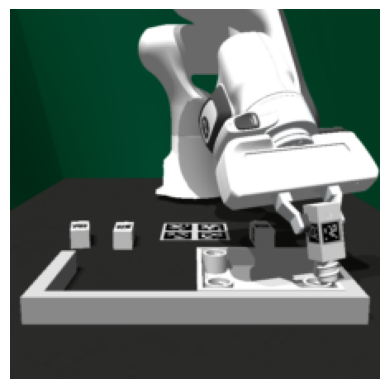

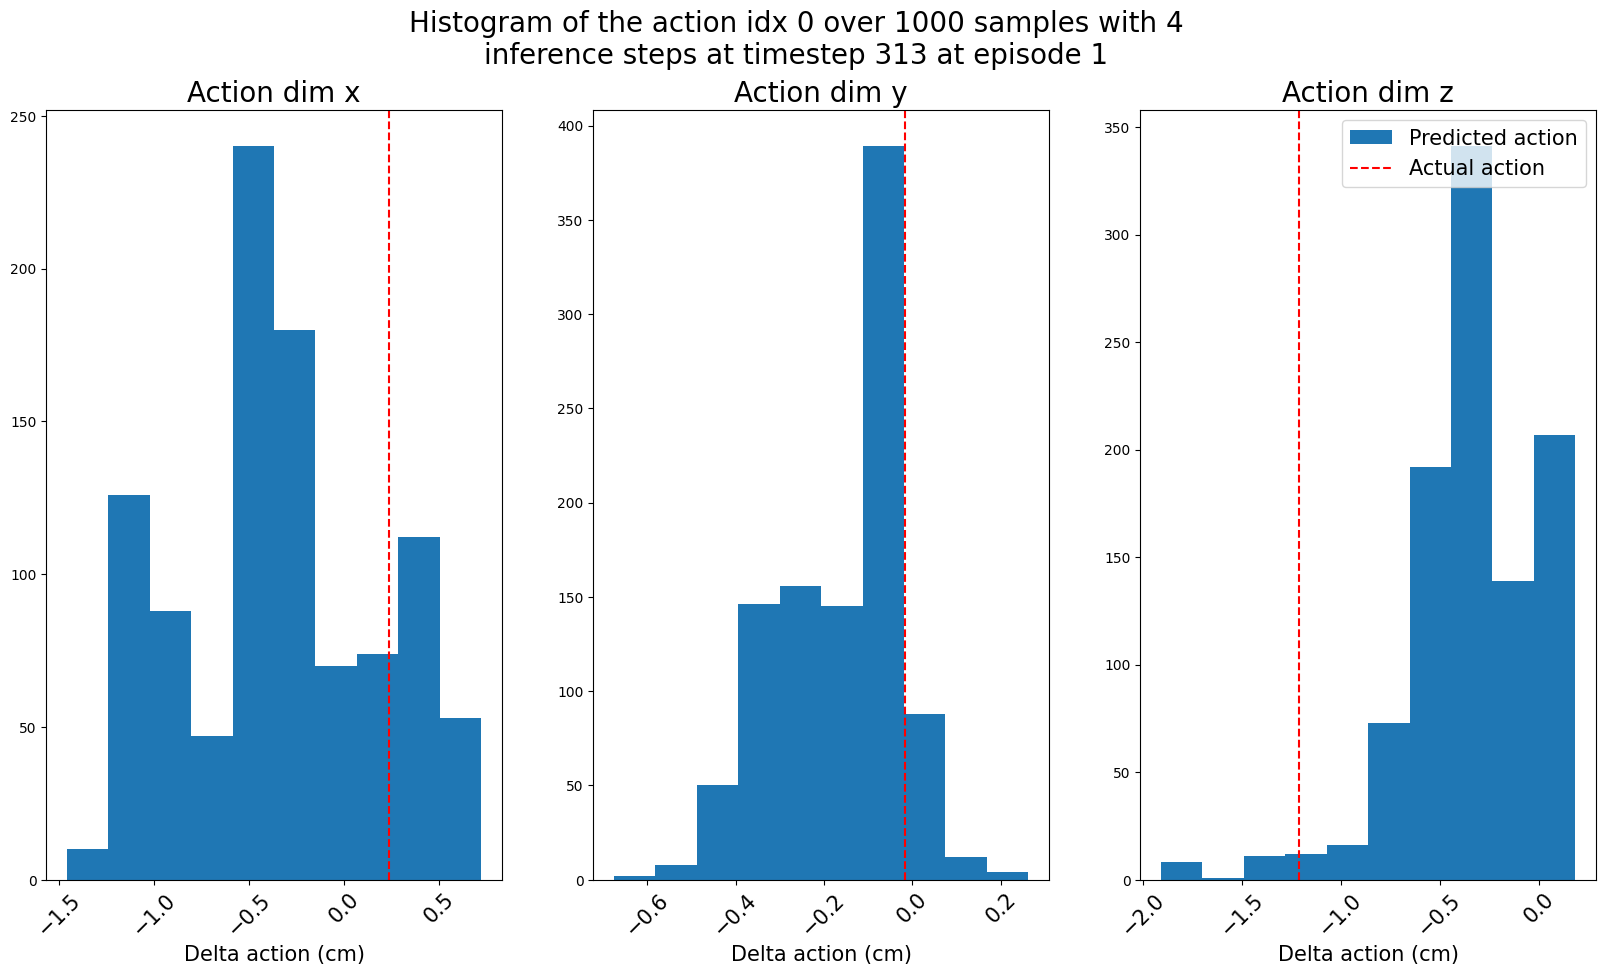

torch.Size([10])
tensor([-0.0017, -0.0014, -0.0058,  0.9998,  0.0079,  0.0070, -0.0089,  0.9997,
         0.0080,  0.9977])
tensor([0.0038, 0.0011, 0.0043, 0.0003, 0.0065, 0.0162, 0.0068, 0.0003, 0.0078,
        0.0051])
tensor([-2.1868e+00, -7.6773e-01, -7.4331e-01,  3.0761e-04,  8.1787e-01,
         2.3162e+00, -7.5613e-01,  2.7896e-04,  9.6784e-01,  5.0793e-03])
0.011382014
0.005629648
0.49460915


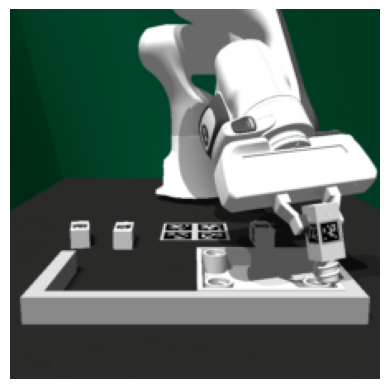

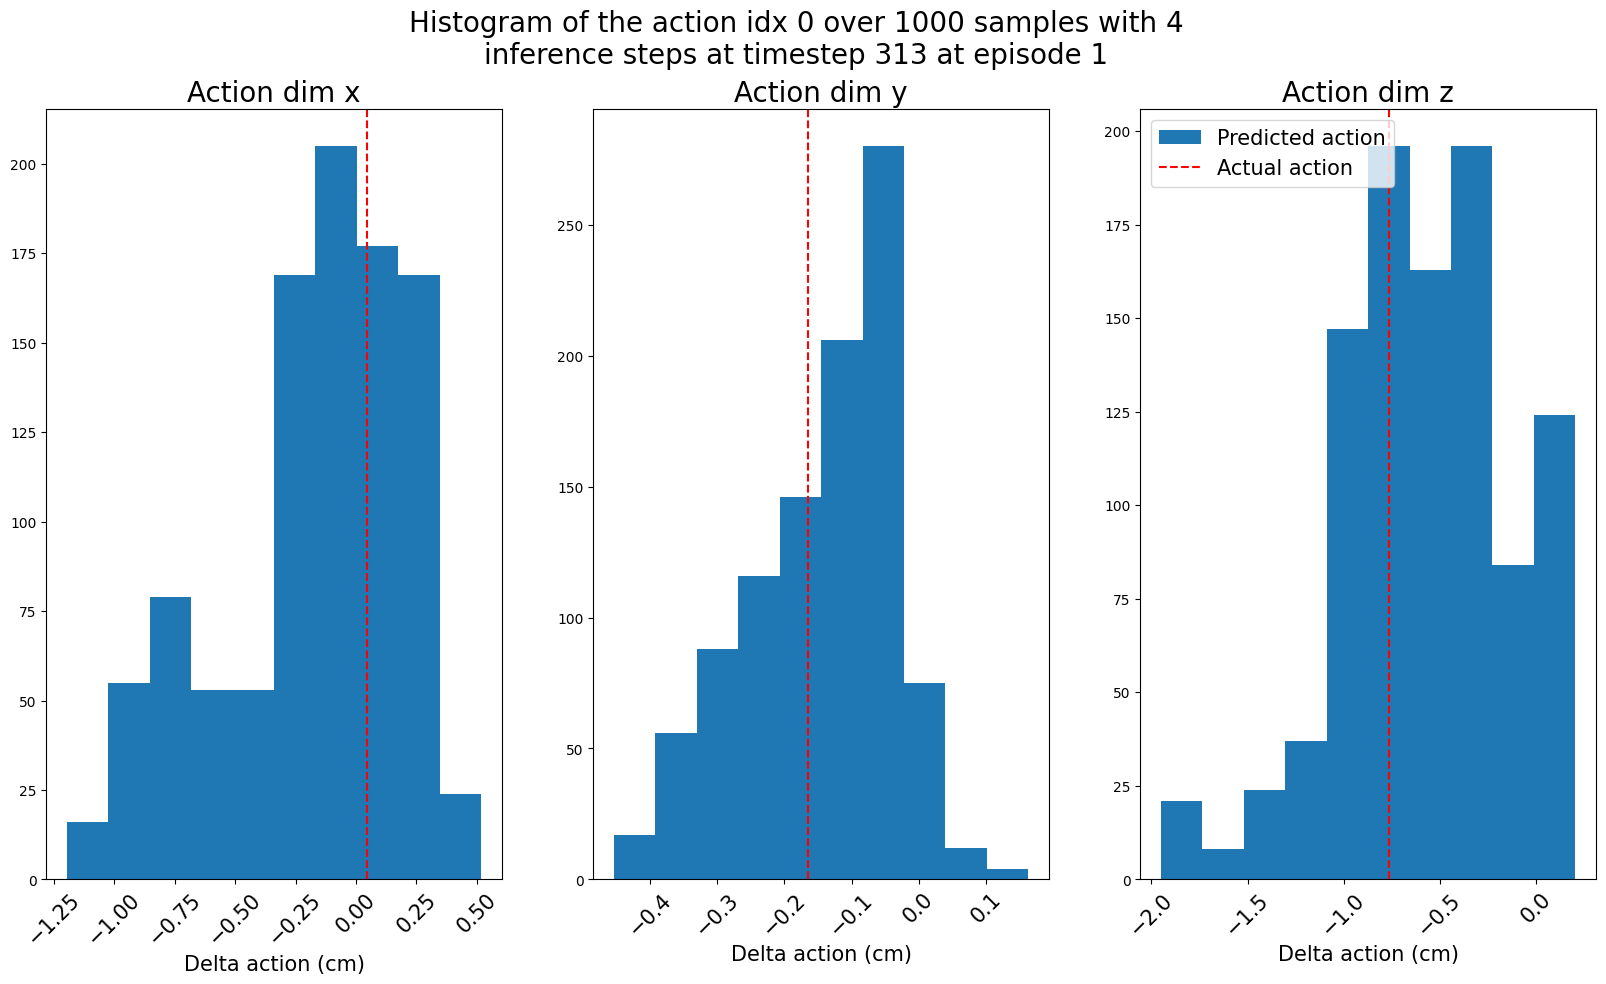

torch.Size([10])
tensor([-1.7662e-03, -8.9740e-04, -1.0786e-02,  9.9982e-01,  8.5162e-03,
         9.0828e-03, -9.4436e-03,  9.9975e-01,  1.3827e-02,  9.9698e-01])
tensor([0.0017, 0.0008, 0.0067, 0.0003, 0.0071, 0.0088, 0.0075, 0.0003, 0.0061,
        0.0058])
tensor([-9.6294e-01, -9.0459e-01, -6.1897e-01,  2.7463e-04,  8.3648e-01,
         9.6693e-01, -7.9583e-01,  2.6429e-04,  4.3820e-01,  5.8188e-03])
0.017001666
0.005871243
0.34533337


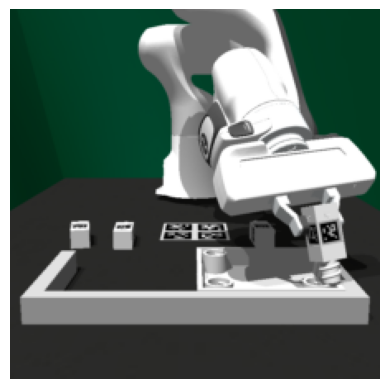

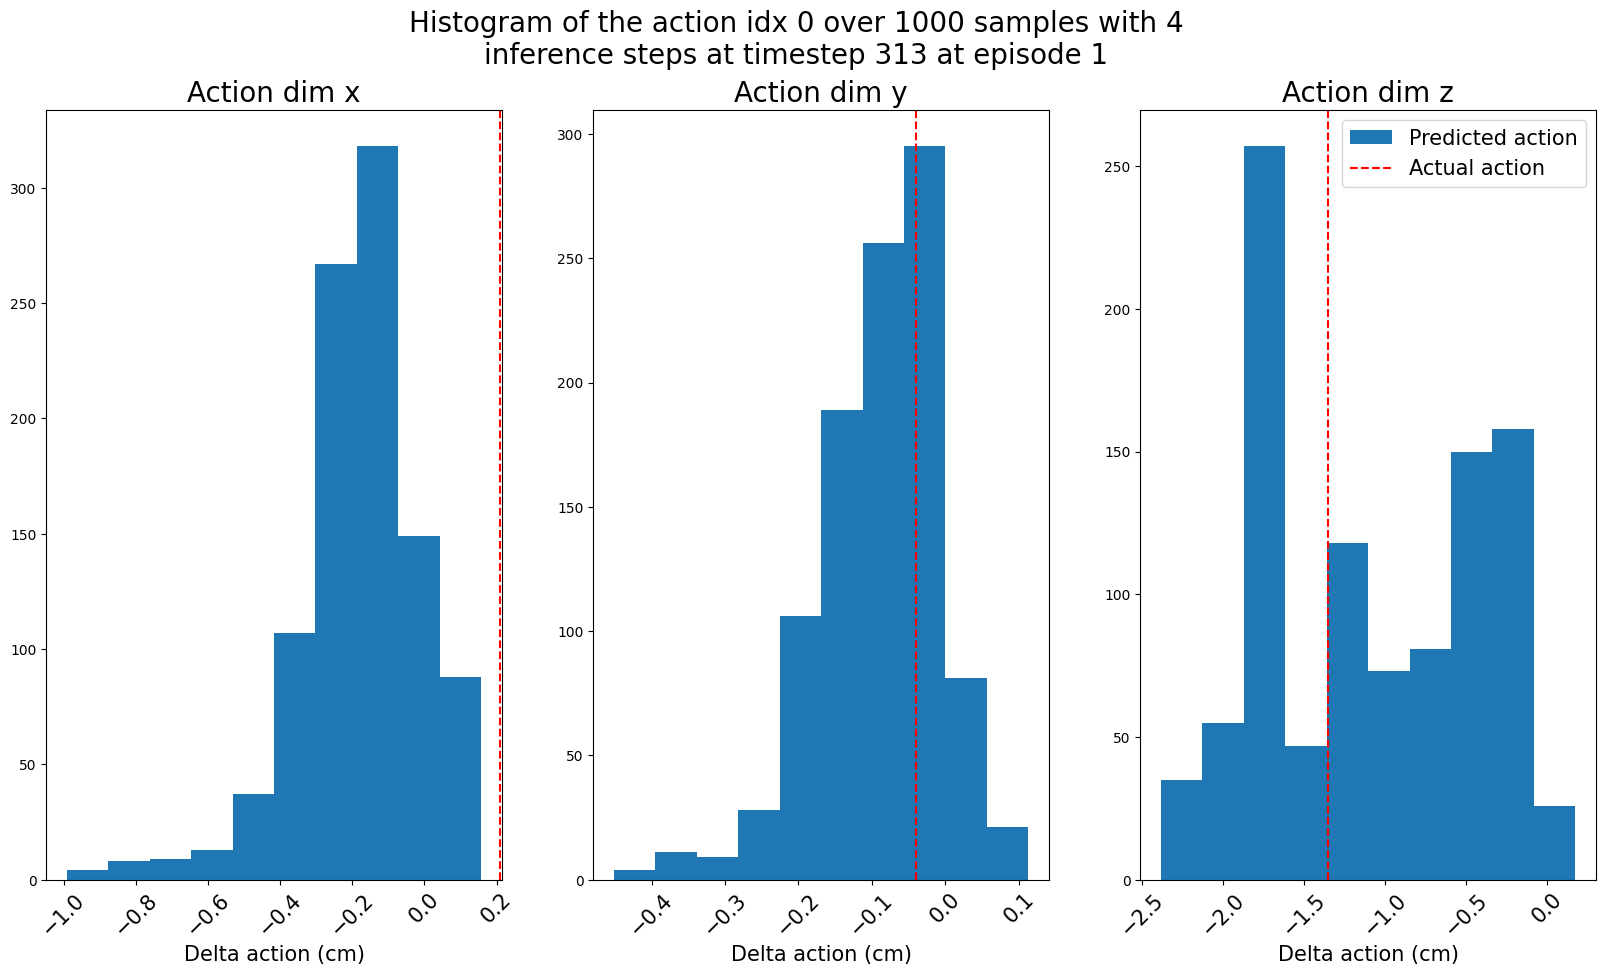

torch.Size([10])
tensor([ 1.1901e-03,  7.4493e-05, -2.2286e-02,  9.9997e-01,  2.1530e-03,
        -4.6363e-03, -4.1495e-03,  9.9983e-01, -7.0949e-03,  9.9992e-01])
tensor([0.0003, 0.0003, 0.0012, 0.0001, 0.0026, 0.0051, 0.0027, 0.0002, 0.0035,
        0.0009])
tensor([ 2.6060e-01,  4.2361e+00, -5.2564e-02,  1.2813e-04,  1.2252e+00,
        -1.0911e+00, -6.4705e-01,  2.1104e-04, -4.9307e-01,  8.7702e-04])
0.010289276
0.010023399
0.97415984


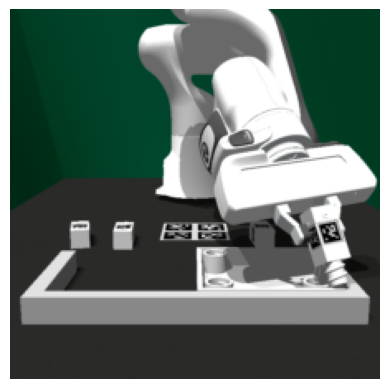

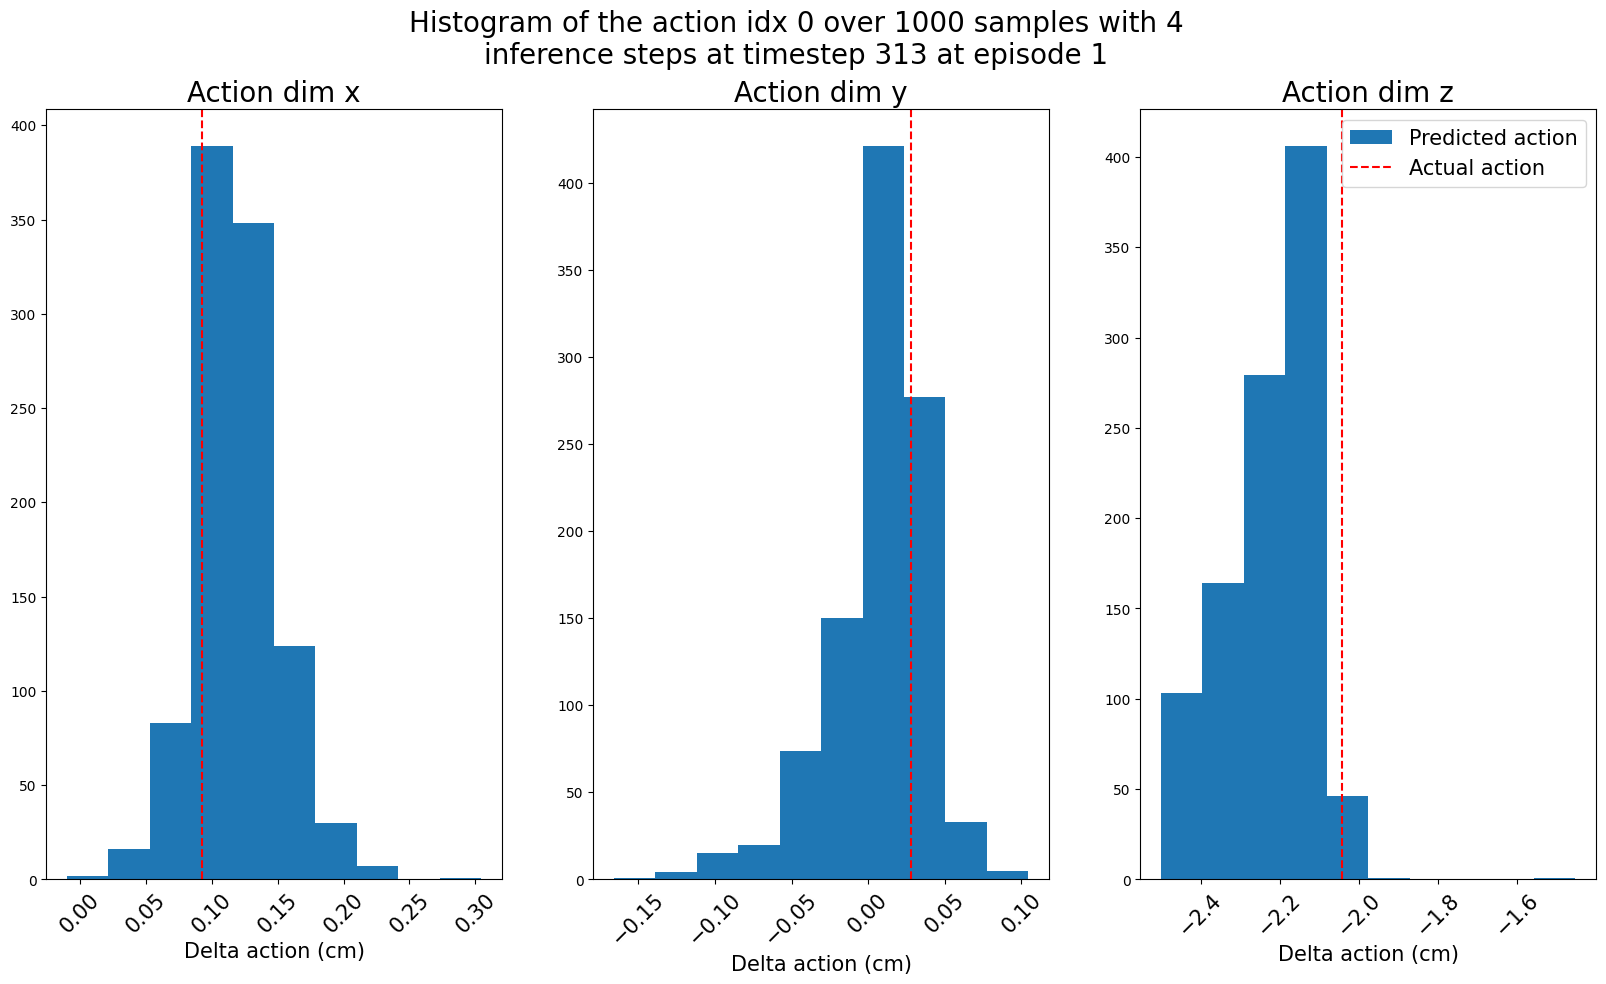

In [268]:
# Plot histograms for the failure dataset
for i in range(600, 499, -10):
    plot_action_histogram(dataset_failure, 1, i)